In [34]:
import math
import matplotlib.pyplot as plt
import os
import subprocess
import sys
import pandas as pd

In [35]:
# pull in our gquery module
sys.path.append('../../scripts')
os.environ['GUFI_CONFIG']='/home/jbent/GUFI/configs/jbent_home'
#os.environ['GUFI_DEBUG']='TRUE'
import gquery as gq

In [3]:
config=gq.query_gconfig()

In [4]:
# construct a query to find the max sized file
select='size'
tables='vrpentries'
where=None
nthreads=config.config['Threads']
indexroot=config.config['IndexRoot']
#indexroot='/mnt/nvme0n1/jbent/jbent_home' # overwrite what the config table has
(command,cstr)=gq.get_gufi_command(select=select,tables=tables,where=where,nthreads=nthreads,indexroot=indexroot)

In [8]:
# now run the query and use the max aggregate
largest_file = gq.execute_command(command=command,command_string=cstr,aggregate_function='max',Verbose=False)

In [30]:
def get_file_count(where):
    select='count(*)'
    tables='vrpentries'
    (command,cstr)=gq.get_gufi_command(select=select,tables=tables,where=where,nthreads=nthreads,indexroot=indexroot)
    count = gq.execute_command(command=command,command_string=cstr,aggregate_function='sum',Verbose=False)
    return count

In [31]:
# now let's build a histogram of all the file counts up to the largest file using powers of 2
max_pow = math.ceil(math.log2(largest_file))
for i in range(max_pow):
    where="size > %d and size <= %d" % ((2**(i-1) if (2**(i-1)>=1) else -1),2**i)
    c = get_file_count(where)
    print(f"Bucket {where} has {c} files.")

Bucket size > -1 and size <= 1 has 215 files.
Bucket size > 1 and size <= 2 has 13 files.
Bucket size > 2 and size <= 4 has 66 files.
Bucket size > 4 and size <= 8 has 14 files.
Bucket size > 8 and size <= 16 has 35 files.
Bucket size > 16 and size <= 32 has 97 files.
Bucket size > 32 and size <= 64 has 118 files.
Bucket size > 64 and size <= 128 has 250 files.
Bucket size > 128 and size <= 256 has 468 files.
Bucket size > 256 and size <= 512 has 616 files.
Bucket size > 512 and size <= 1024 has 978 files.
Bucket size > 1024 and size <= 2048 has 1329 files.
Bucket size > 2048 and size <= 4096 has 1726 files.
Bucket size > 4096 and size <= 8192 has 1474 files.
Bucket size > 8192 and size <= 16384 has 964 files.
Bucket size > 16384 and size <= 32768 has 598 files.
Bucket size > 32768 and size <= 65536 has 252 files.
Bucket size > 65536 and size <= 131072 has 120 files.
Bucket size > 131072 and size <= 262144 has 47 files.
Bucket size > 262144 and size <= 524288 has 96 files.
Bucket size 

In [7]:
sorted(gq.aggregate_functions.keys())

['count', 'distinct', 'max', 'mean', 'median', 'min', 'mode', 'stdev', 'sum']

In [36]:
data = {
    'Lower_Bound': [-1, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216],
    'Upper_Bound': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432],
    'Num_Files': [215, 13, 66, 14, 35, 97, 118, 250, 468, 616, 978, 1329, 1726, 1474, 964, 598, 252, 120, 47, 96, 29, 36, 9, 36, 1, 4]
}

df = pd.DataFrame(data)


In [42]:
# a function to make nice tic marks on the graph
def generate_custom_ticks_labels(max_size):
    i = 1  # Start size
    factor = 1  # Byte multiplier
    label = "B"  # Initial label
    custom_ticks = []
    custom_labels = []

    while i <= max_size:
        custom_ticks.append(i)
        
        if i == 1024:
            factor = i
            label = "K"
        elif i == 1048576:
            factor = i
            label = "M"  
        elif i == 1048576 * 1024:
            factor = i
            label = "G"
        elif i == 1048576 * 1048576:
            factor = i
            label = "T"
        elif i == 1048576 * 1048576 * 1024:
            factor = i
            label = "P"
            
        custom_labels.append(f"{i//factor}{label}")
        i *= 2  # Increase size in powers of 2
        
    return custom_ticks, custom_labels

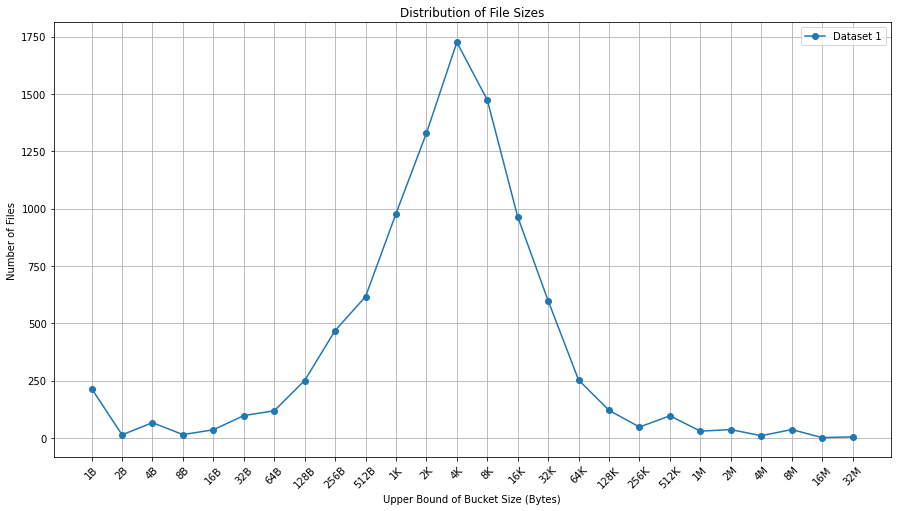

In [44]:
plt.figure(figsize=(15, 8))

custom_ticks, custom_labels = generate_custom_ticks_labels(largest_file)

# Plot the data as a line graph
plt.plot(df['Upper_Bound'], df['Num_Files'], marker='o', label='Dataset 1')

plt.xscale('log', base=2)

# Add labels and title
plt.xlabel('Upper Bound of Bucket Size (Bytes)')
plt.ylabel('Number of Files')
plt.title('Distribution of File Sizes')

# Add grid and legend
plt.grid(True)
plt.legend()
plt.xticks(custom_ticks, custom_labels, rotation=45)

# Show the graph
plt.show()
